<a href="https://colab.research.google.com/github/Euan-J-Austin/Analytics_and_Intelligence/blob/main/ProphetChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Prepare
2. Training and test set
3. Create model and access accuracy
4. Visualize output
5. Tune parameters

# Data and Libraries

In [ ]:
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [ ]:
df = pd.read_csv('/content/DHS_weekly.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          366 non-null    object 
 1   Total Individuals in Shelter  366 non-null    int64  
 2   Easter                        366 non-null    int64  
 3   Thanksgiving                  366 non-null    int64  
 4   Christmas                     366 non-null    int64  
 5   Temperature                   366 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 17.3+ KB


In [ ]:
df = df.rename(columns={'Total Individuals in Shelter': 'Shelter_Total'})

In [ ]:
df.describe()

,Shelter_Total,Easter,Thanksgiving,Christmas,Temperature
count,366.000000,366.000000,366.000000,366.000000,366.000000
mean,405042.808743,0.019126,0.019126,0.019126,14.842424
std,19375.509125,0.137154,0.137154,0.137154,8.511113
min,212514.000000,0.000000,0.000000,0.000000,-4.318571
25%,397040.250000,0.000000,0.000000,0.000000,7.503571
50%,408495.000000,0.000000,0.000000,0.000000,14.918571
75%,418908.750000,0.000000,0.000000,0.000000,22.792143
max,428607.000000,1.000000,1.000000,1.000000,28.535714


<Axes: >

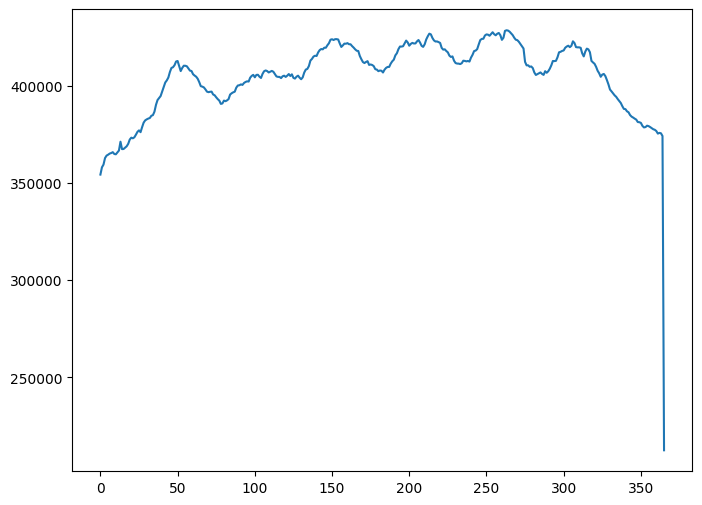

In [ ]:
df.Shelter_Total.plot(figsize=(8,6))

# Formatting the data

## Date

In [ ]:
df.Date

0        1/5/2014
1       1/12/2014
2       1/19/2014
3       1/26/2014
4        2/2/2014
          ...    
361     12/6/2020
362    12/13/2020
363    12/20/2020
364    12/27/2020
365      1/3/2021
Name: Date, Length: 366, dtype: object

In [ ]:
# %m/%d/%Y --> %Y-%m-%d

df.Date = pd.to_datetime(df.Date,
                         format = '%m/%d/%Y')

df.Date

0     2014-01-05
1     2014-01-12
2     2014-01-19
3     2014-01-26
4     2014-02-02
         ...    
361   2020-12-06
362   2020-12-13
363   2020-12-20
364   2020-12-27
365   2021-01-03
Name: Date, Length: 366, dtype: datetime64[ns]

## Renaming variables

In [ ]:
df.head(0)

,Date,Shelter_Total,Easter,Thanksgiving,Christmas,Temperature


In [ ]:
df = df.rename(columns = {'Date': 'ds',
                          'Shelter_Total': 'y',})

df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature


## Dynamic holidays

In df, ds data is the week ending that contained the holiday e.g. YYYY-12-24. It's superfluous to create a window around these dates as a week captures the holiday season.

As regards Christmas, we could create an upper window to capture the New Year but for simplicity we will exclude that week from the Christmas period.

In [ ]:
df[df.Christmas==1]

,ds,y,Easter,Thanksgiving,Christmas,Temperature
51,2014-12-28,410303,0,0,1,9.670000
103,2015-12-27,404725,0,0,1,14.192857
155,2016-12-25,421814,0,0,1,4.711429
208,2017-12-31,420626,0,0,1,-1.812857
260,2018-12-30,423687,0,0,1,6.442857
312,2019-12-29,416756,0,0,1,7.712857
364,2020-12-27,374203,0,0,1,7.510000


In [ ]:
easter_dates = df[df.Easter==1].ds

In [ ]:
#NB, windows are measured always in days

easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': easter_dates,
    'lower_window': -7,
    'upper_window': 7})

easter

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7
171,easter,2017-04-16,-7,7
221,easter,2018-04-01,-7,7
276,easter,2019-04-21,-7,7
327,easter,2020-04-12,-7,7


In [ ]:
christmas_dates = df[df.Christmas==1].ds

In [ ]:
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': christmas_dates,
    'lower_window': -7,
    'upper_window': 7})

christmas

,holiday,ds,lower_window,upper_window
51,christmas,2014-12-28,-7,7
103,christmas,2015-12-27,-7,7
155,christmas,2016-12-25,-7,7
208,christmas,2017-12-31,-7,7
260,christmas,2018-12-30,-7,7
312,christmas,2019-12-29,-7,7
364,christmas,2020-12-27,-7,7


In [ ]:
holidays = pd.concat([easter, christmas])

In [ ]:
df = df.drop(columns = ['Easter', 'Christmas'])
df.head(0)

,ds,y,Thanksgiving,Temperature


#Train Test Split

Let's say we're trying to predict the next month of shelter demand

In [ ]:
test_weeks = 4
training = df.iloc[:-test_weeks,:]
test = df.iloc[-test_weeks:,:]

In [ ]:
print(test.head(1))

            ds       y  Thanksgiving  Temperature
362 2020-12-13  375820             0     8.208571


In [ ]:
print(training.tail(1))

            ds       y  Thanksgiving  Temperature
361 2020-12-06  375444             0    10.072857


# Prophet model

In [ ]:
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = False,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'multiplicative', #Diogo's suggestion was multiplicative, but I beleive by the plot seasonality isn't growing with the trend
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)

m.add_regressor('Thanksgiving')
m.add_regressor('Temperature')
m.fit(training)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpe1ltspl1/hd_gboey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe1ltspl1/w_y276y9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37959', 'data', 'file=/tmp/tmpe1ltspl1/hd_gboey.json', 'init=/tmp/tmpe1ltspl1/w_y276y9.json', 'output', 'file=/tmp/tmpe1ltspl1/prophet_modelwgb3fs4_/prophet_model-20230619045841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:58:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:58:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Coefs
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Thanksgiving,multiplicative,0.000000,-0.000286,-0.000286,-0.000286
1,Temperature,multiplicative,14.934939,-0.000239,-0.000239,-0.000239


#Forecasting

In [ ]:
future = m.make_future_dataframe(periods = test_weeks,
                                     freq = 'W')

In [ ]:
future  = pd.concat([future, df.iloc[:,2:]],
                    axis = 1)

In [ ]:
future.tail()

,ds,Thanksgiving,Temperature
361,2020-12-06,0,10.072857
362,2020-12-13,0,8.208571
363,2020-12-20,0,3.535714
364,2020-12-27,0,7.510000
365,2021-01-03,0,6.625000


In [ ]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Temperature,Temperature_lower,Temperature_upper,Thanksgiving,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-05,351257.580531,353500.365974,359915.005824,351257.580531,351257.580531,0.003371,0.003371,0.003371,0.0,...,0.015427,0.015427,0.015427,0.012055,0.012055,0.012055,0.0,0.0,0.0,356676.353687
1,2014-01-12,352561.008849,354833.957447,361374.261541,352561.008849,352561.008849,0.002795,0.002795,0.002795,0.0,...,0.016243,0.016243,0.016243,0.013448,0.013448,0.013448,0.0,0.0,0.0,358287.517159
2,2014-01-19,353864.437167,356992.979293,363689.383936,353864.437167,353864.437167,0.002226,0.002226,0.002226,0.0,...,0.018129,0.018129,0.018129,0.015903,0.015903,0.015903,0.0,0.0,0.0,360279.624616
3,2014-01-26,355167.865485,359475.164268,366138.275910,355167.865485,355167.865485,0.004017,0.004017,0.004017,0.0,...,0.021451,0.021451,0.021451,0.017434,0.017434,0.017434,0.0,0.0,0.0,362786.468814
4,2014-02-02,356471.293803,360024.305804,367053.417791,356471.293803,356471.293803,0.003293,0.003293,0.003293,0.0,...,0.020178,0.020178,0.020178,0.016885,0.016885,0.016885,0.0,0.0,0.0,363664.037542


#Event assessment

In [ ]:
#Holiday assessment
holiday = 'easter'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,easter
326,2020-04-05,-0.003319
327,2020-04-12,-0.004019
328,2020-04-19,-0.003062


In [ ]:
#Holiday assessment
holiday = 'christmas'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,christmas
313,2020-01-05,-0.003066
363,2020-12-20,0.001794
364,2020-12-27,-0.001321
365,2021-01-03,-0.003066


#Accuracy assessment

In [ ]:
predictions = forecast.yhat[-test_weeks:]

In [ ]:
 np.sqrt(mean_squared_error(test['y'], predictions))

84623.01451456524

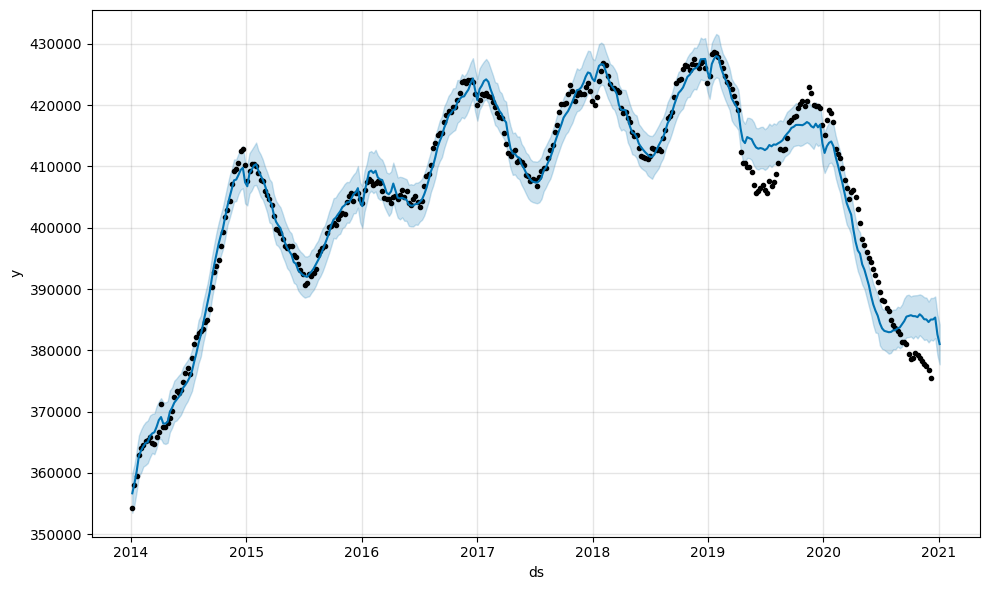

In [ ]:
m.plot(forecast);

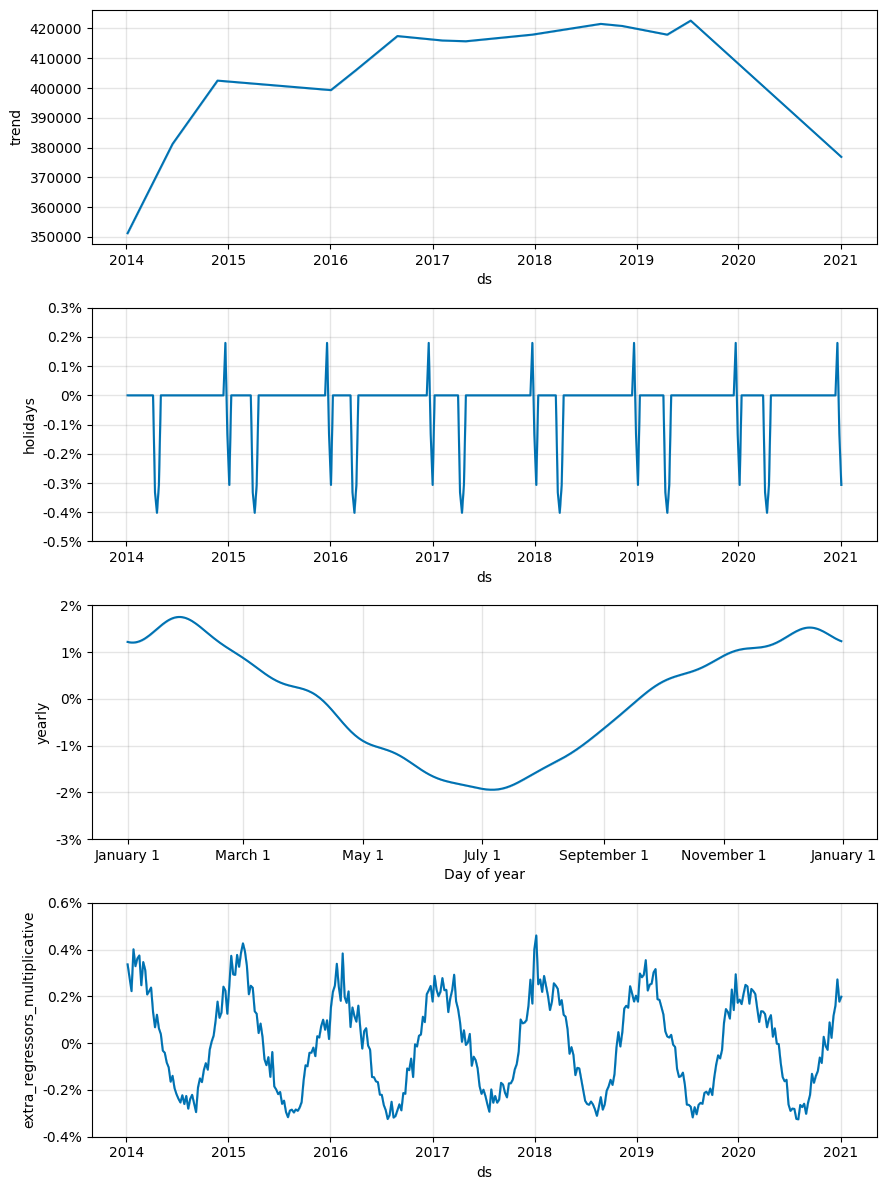

In [ ]:
m.plot_components(forecast);

#Cross-validation

In [ ]:
df.shape

(366, 4)

In [ ]:
df_cv = cross_validation(m,
                 horizon = '4 W',
                 initial = '300 W',
                 parallel = 'processes')

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,419402.564405,418181.575645,420715.550104,420265,2019-10-13
1,2019-10-27,420003.707110,418673.385803,421411.074082,420670,2019-10-13
2,2019-11-03,420693.143062,419245.622871,421910.543043,419924,2019-10-13
3,2019-11-10,421243.370267,419762.803944,422692.509247,420624,2019-10-13
4,2019-11-03,420771.718329,419536.132053,422100.401413,419924,2019-10-27


In [ ]:
#Error assessment
print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

6576.5237025223005
8477.417642805673


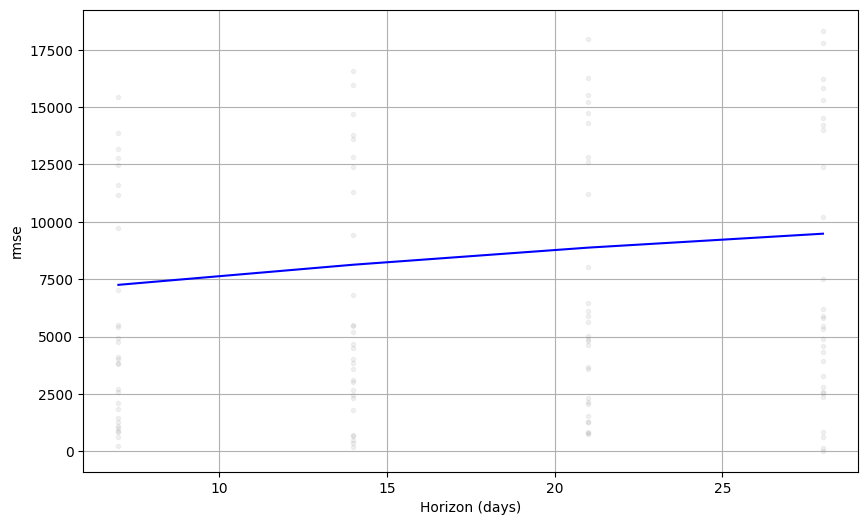

In [ ]:
plot_cross_validation_metric(df_cv,
                             metric = 'rmse');

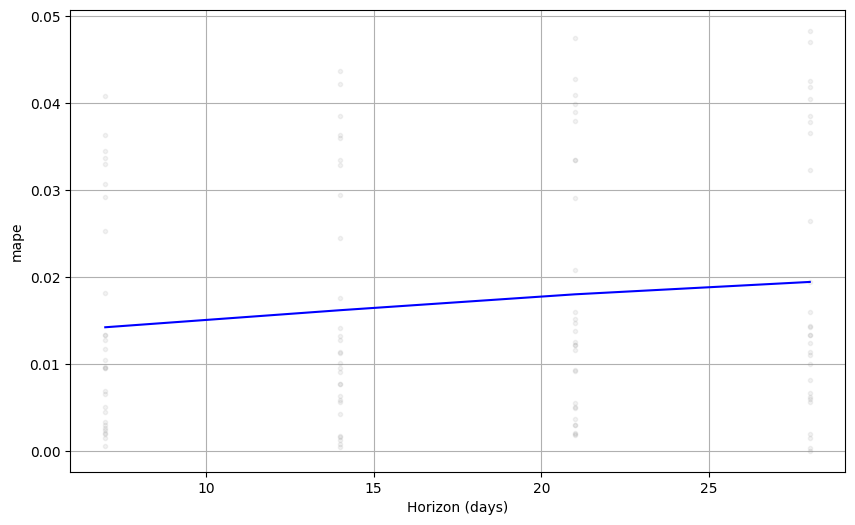

In [ ]:
plot_cross_validation_metric(df_cv,
                             metric = 'mape');

Relatively stable, upward trend as future is unstable



In [ ]:
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

54

In [ ]:
#Empty list to store results
rmse = []
#start the loop
for params in grid:
  #build the model
  m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = False,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = params['seasonality_mode'],
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale= params['changepoint_prior_scale'])
  m.fit(training)

  #Cross-Validation
  df_cv = cross_validation(m,
                           horizon = '4 W',
                           initial = '300 W',
                           parallel = 'processes')

  #Measure and store results
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)

In [ ]:
#Get the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,9091.185377
1,0.01,5,additive,10,9048.434074
2,0.01,5,additive,20,9051.857669
3,0.01,5,multiplicative,5,8955.490435
4,0.01,5,multiplicative,10,8978.919125
5,0.01,5,multiplicative,20,8981.204331
6,0.01,10,additive,5,9089.115652
7,0.01,10,additive,10,9074.581494
8,0.01,10,additive,20,9054.265218
9,0.01,10,multiplicative,5,8940.929948


In [ ]:
tuning_results.min()

changepoint_prior_scale           0.01
holidays_prior_scale                 5
seasonality_mode              additive
seasonality_prior_scale              5
rmse                       8298.320521
dtype: object

#Applying tuned params

In [ ]:
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = False,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'additive',
            seasonality_prior_scale = 5,
            holidays_prior_scale = 5,
            changepoint_prior_scale = 0.01)

m.add_regressor('Thanksgiving')
m.add_regressor('Temperature')
m.fit(training)

In [ ]:
future = m.make_future_dataframe(periods = test_weeks,
                            freq = 'W')
future  = pd.concat([future, df.iloc[:,2:]],
                    axis = 1)

In [ ]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Temperature,Temperature_lower,Temperature_upper,Thanksgiving,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-05,356991.913584,357091.262394,366598.664844,356991.913584,356991.913584,2931.813125,2931.813125,2931.813125,0.0,...,0.0,0.0,0.0,1691.526891,1691.526891,1691.526891,0.0,0.0,0.0,361615.253601
1,2014-01-12,357944.388755,358239.978637,367432.967551,357944.388755,357944.388755,2430.415587,2430.415587,2430.415587,0.0,...,0.0,0.0,0.0,2644.553584,2644.553584,2644.553584,0.0,0.0,0.0,363019.357926
2,2014-01-19,358896.863926,360578.553025,369820.083429,358896.863926,358896.863926,1935.975297,1935.975297,1935.975297,0.0,...,0.0,0.0,0.0,4168.757176,4168.757176,4168.757176,0.0,0.0,0.0,365001.596399
3,2014-01-26,359849.339096,363543.966348,373286.933349,359849.339096,359849.339096,3493.328419,3493.328419,3493.328419,0.0,...,0.0,0.0,0.0,5022.263475,5022.263475,5022.263475,0.0,0.0,0.0,368364.930990
4,2014-02-02,360801.814267,363826.060190,372821.559082,360801.814267,360801.814267,2863.310995,2863.310995,2863.310995,0.0,...,0.0,0.0,0.0,4697.086065,4697.086065,4697.086065,0.0,0.0,0.0,368362.211327


In [ ]:
predictions = forecast.yhat[-test_weeks:]

In [ ]:
print(mean_absolute_error(test.y, predictions))
print(np.sqrt(mean_squared_error(test.y, predictions)))

50867.39754141688
85572.97688794663


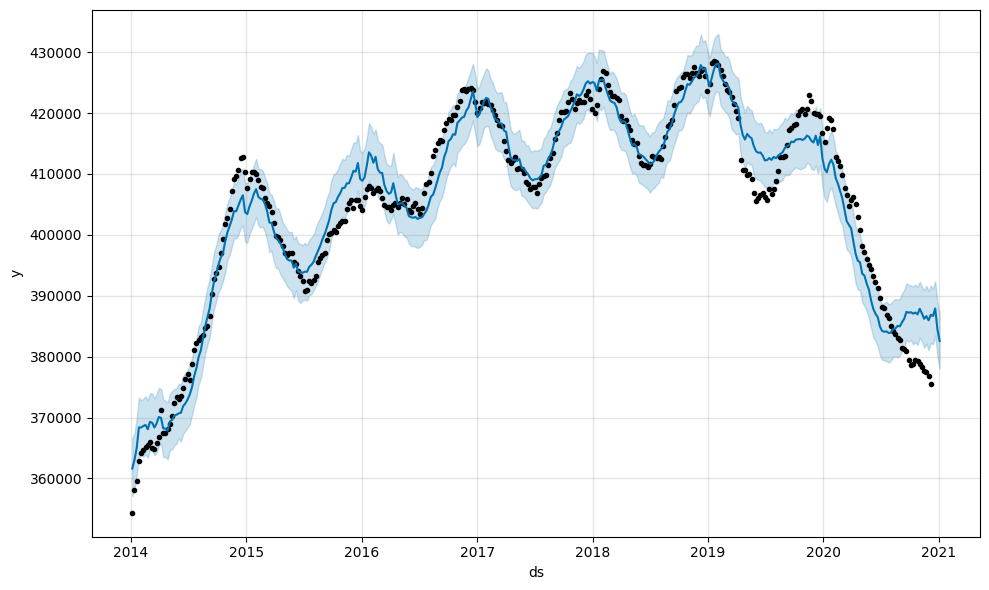

In [ ]:
m.plot(forecast);

Seems to have slightly worse predictive power, judging by RSME, than the original model.

Now, let's apply a cross-validation.

In [ ]:
df_cv = cross_validation(m,
                 horizon = '4 W',
                 initial = '300 W',
                 parallel = 'processes')

In [ ]:
print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

7118.58073693302
9112.370856857624


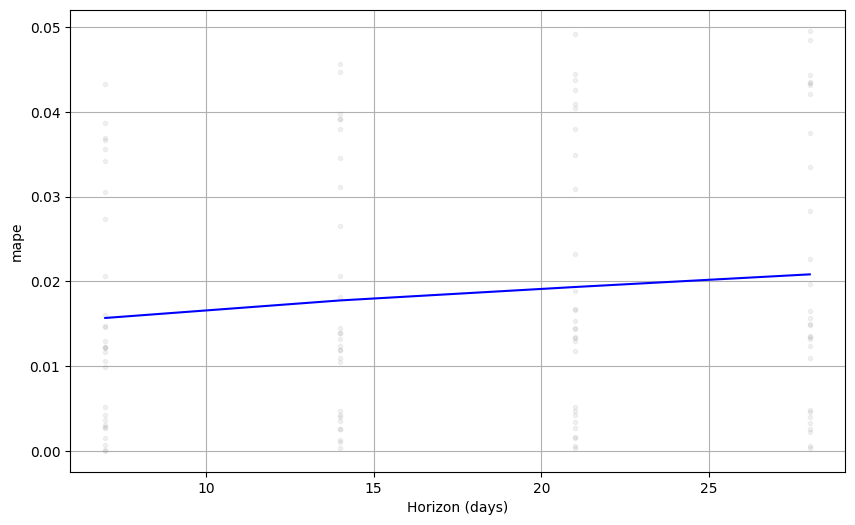

In [ ]:
plot_cross_validation_metric(df_cv,
                             metric = 'mape');

Again, slightly worse than the original model as cross-validation reinforces the model's evaluation.

"It's not uncommon to see the performance metrics slightly degrade after tuning the model. This can be because of overfitting during hyperparameter tuning, or sometimes the validation set used for tuning is not representative enough.

One step that helps when applying these techniques to your professional career is Business Understanding and Feature Engineering. Most often the key lies in the features. Maybe some additional feature engineering or incorporating domain knowledge can help improve the model.

Remember that the process is iterative. Depending on the problem, data, and the model, the approach might vary. It's also important to have a clear understanding of what performance metric is crucial for your business problem, and sometimes small degradations might be within an acceptable range." - D.R.